# [NSF] Sentiment Analysis_Polarity Analysis
### @Author : Woojin Park, Nidhi Bhaskar
### @Copyright : 2020, Neolth NSF grant NLP project 
### @Email : woojinpa@andrew.cmu.edu , nidhibha@andrew.cmu.edu
### @Status : In-Progress

In [1]:
### Import Relevant Libraries
import os
import pandas as pd
import numpy as np
import collections
import datetime as dt
import requests
import json
import re
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import norm

import string
import re
import nltk
from nltk.util import ngrams
from nltk import pos_tag,word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
### Build a get_date function to convert date format
#### Build a data_creation function to read json data into pandas dataframe

def get_date(created):
    return dt.datetime.fromtimestamp(created)

def data_creation(subreddit) : 
    with open('submissions_'+subreddit+'.json') as f:
        data = json.loads("[" + 
            f.read().replace("}\n{", "},\n{") + 
        "]")
    data =pd.DataFrame(data)
    reddit_data = data[['author','over_18','title','selftext','num_comments', 'score', 'full_link','created_utc']]
    reddit_data = reddit_data.dropna()
    _timestamp = reddit_data["created_utc"].apply(get_date)
    reddit_data = reddit_data.assign(timestamp = _timestamp)
    reddit_data['over_18'] = reddit_data['over_18'].astype('str')
    reddit_data['subreddit']= subreddit
    # Build column have title + selftext
    reddit_data['title_with_selftext']= reddit_data['title'] +" " + reddit_data['selftext']

    # Do one more extra cleaning : keep updating this part
    reddit_data=reddit_data[~reddit_data['title_with_selftext'].isin([ '[removed]', '[deleted]',''])]
    subreddit = reddit_data
    
    return subreddit

def empty_words_clean(text):
    text = text.replace('[removed]','')
    text= text.replace('[deleted]','')
    text= text.replace('\n','')
    return (text)

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
### Dataframing 4 subreddit Datasets
SuicideWatch_df = data_creation('SuicideWatch')
depressed_df = data_creation('depressed')
happy_df = data_creation('happy')
selfimprovement_df = data_creation('selfimprovement')

### Concat all 4 dataframes into one merged file
all_subreddit_df = pd.concat([SuicideWatch_df,depressed_df,happy_df,selfimprovement_df])
all_subreddit_df.head(2)

author over_18                                              title  \
0    DespressoCafe   False  I don't know where to go or what to do. I can'...   
1  LifeisCrumbling   False                   I'm having an existencial crisis   

                                            selftext  num_comments  score  \
0  Let's make it quick. I'm almost 20. I've been ...             5      1   
1  If I only helped people either as a defense me...             1      1   

                                           full_link  created_utc  \
0  https://www.reddit.com/r/SuicideWatch/comments...   1579669252   
1  https://www.reddit.com/r/SuicideWatch/comments...   1579669256   

            timestamp     subreddit  \
0 2020-01-22 00:00:52  SuicideWatch   
1 2020-01-22 00:00:56  SuicideWatch   

                                 title_with_selftext  
0  I don't know where to go or what to do. I can'...  
1  I'm having an existencial crisis If I only hel...

# Sentiment Analysis 

### Polarity Analysis

Sentiment analysis is basically the process of determining the attitude or the emotion of the writer,
i.e., whether it is positive or negative or neutral.

The sentiment function of textblob returns polarity.
Polarity is float which lies in the range of [-1,1] where 1 means positive statement , -1 means a negative statement
and 0 means a neutral statement.

### 0.Data Preparation

In [68]:
### Text Preprocessing by following pipeline : 
### Raw text => Tokeninze/lowercase => Remove stop words => Remove non-alphabetic characters => 
### Remove Extra Punctuations => Lemmatization => Build Custom Stop words dictionary 

In [167]:
# Build function that takes a word and returns true if it consists only of non-alphabetic characters
def alpha_filter(w):
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False
    
# Build data preparation function including all the necessary 7 steps :
def clean_words(text):
    # lower text & tokenizing
    text = text.replace('\n',' ')
    text = text.replace('[removed]',' ')
    text= text.replace('[deleted]', '')
    text =text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]',r' ',text) #remove anything that is not a letter or number first
    text = [word for word in text.split(" ")]
    # remove stop words
    nltk_stopwords = set(stopwords.words('english'))
    review_lower_stop = [x for x in text if not x in nltk_stopwords]
    # remove extra punctuations
    review_lower_stop_pun = [y for y in review_lower_stop if not alpha_filter(y)]
    review_lower_stop_pun_extra = [''.join(x for x in par if x not in string.punctuation) for par in review_lower_stop_pun]

    # Lemmatization
    porter = WordNetLemmatizer()
    review_lower_stop_pun_extra_lemmatized = []
    for a in review_lower_stop_pun_extra : 
        review_lower_stop_pun_extra_lemmatized.append(porter.lemmatize(a))
    # buid custom stop words dictionary
    cachedStopWords = set(stopwords.words("english"))

    ####Keep Updating custom stop words
    cachedStopWords.update(('nt', 'wo', 're', 'im', 'yall','u','ca','ive', 'wan','na','gon','nov','x200b','amp',\
                        'wwwyoutubecomwatch','http','vbjkbl5olvm8','lt', 'br', 'gt', 'amp','tsp','tbsp','nbsp'))
    
    review_lower_stop_pun_extra_lemmatized_stop = [x for x in review_lower_stop_pun_extra_lemmatized\
                                                   if not x in cachedStopWords]
    text = " ".join(review_lower_stop_pun_extra_lemmatized_stop)
    return (text)

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

### 1.SuicideWatch

In [168]:
### Because of relatively huge dataset, we need to perform random sampling of 50% for now
sampleSuicideWatch_list = SuicideWatch_df.sample(frac=0.3, replace=True, random_state=1)

In [169]:
sampleSuicideWatch_list["title_with_selftext_clean"] = sampleSuicideWatch_list["title_with_selftext"].apply(lambda x: clean_words(x))

In [170]:
#Print out the example cases

In [171]:
sampleSuicideWatch_list.tail(1)

author over_18                 title  \
24133  em3e3   False  can i have a friend?   

                                                selftext  num_comments  score  \
24133  I need to speak, I need someone, I need to exp...             5      1   

                                               full_link  created_utc  \
24133  https://www.reddit.com/r/SuicideWatch/comments...   1585189187   

                timestamp     subreddit  \
24133 2020-03-25 22:19:47  SuicideWatch   

                                     title_with_selftext  \
24133  can i have a friend? I need to speak, I need s...   

                               title_with_selftext_clean  
24133  friend  need speak  need someone  need express...

In [172]:
sampleSuicideWatch_list["title_with_selftext_clean"].tail(3).tolist()

['could kill matter could slit wrist razor hidden closet think would make difference  think anyone life would care cry parent  know whether make want laugh cry ',
 'death hood anyone researched exit bag death hood    effective  anything anyone know    assume acquiring helium tank easy  sure type helium use tank pressure ',
 'friend  need speak  need someone  need express feeling    want fly away angel tonight']

In [173]:
sampleSuicideWatch_list['polarity'] = sampleSuicideWatch_list['title_with_selftext_clean'].apply(detect_polarity)

In [174]:
sampleSuicideWatch_list.tail(3)

author over_18  \
24617  johnnie_walker_black   False   
7245        LemonCandyPants   False   
24133                 em3e3   False   

                                            title  \
24617  I could kill myself and it wouldn’t matter   
7245                                  Death Hoods   
24133                        can i have a friend?   

                                                selftext  num_comments  score  \
24617  I could slit my wrists with the razor I have h...             0      1   
7245   Has anyone researched Exit Bags/Death Hoods?  ...             1      1   
24133  I need to speak, I need someone, I need to exp...             5      1   

                                               full_link  created_utc  \
24617  https://www.reddit.com/r/SuicideWatch/comments...   1585289182   
7245   https://www.reddit.com/r/SuicideWatch/comments...   1581402014   
24133  https://www.reddit.com/r/SuicideWatch/comments...   1585189187   

                timestamp     subreddit  \
24617 2020-03-27 02:06:22  SuicideWatch   
7245  2020-02-11 01:20:14  SuicideWatch   
24133 2020-03-25 22:19:47  SuicideWatch   

                                     title_with_selftext  \
24617  I could kill myself and it wouldn’t matter I c...   
7245   Death Hoods Has anyone researched Exit Bags/De...   
24133  can i have a friend? I need to speak, I need s...   

                               title_with_selftext_clean  polarity  
24617  could kill matter could slit wrist razor hidde...  0.066667  
7245   death hood anyone researched exit bag death ho...  0.511111  
24133  friend  need speak  need someone  need express...  0.800000

In [175]:
# Check what is the most negative postings looks like 

In [176]:
extreme_example =sampleSuicideWatch_list[sampleSuicideWatch_list['polarity']==-1.0]

In [179]:
extreme_example['title_with_selftext'].head(3)

2160                Night terrors are terrifying [removed]
39630    Literally want to give up Never felt so disgus...
31608                       I’m a pathetic loser [deleted]
Name: title_with_selftext, dtype: object

In [180]:
extreme_example['title_with_selftext_clean'].head(3)

2160                     night terror terrifying  
39630    literally want give never felt disgusting
31608                              pathetic loser 
Name: title_with_selftext_clean, dtype: object

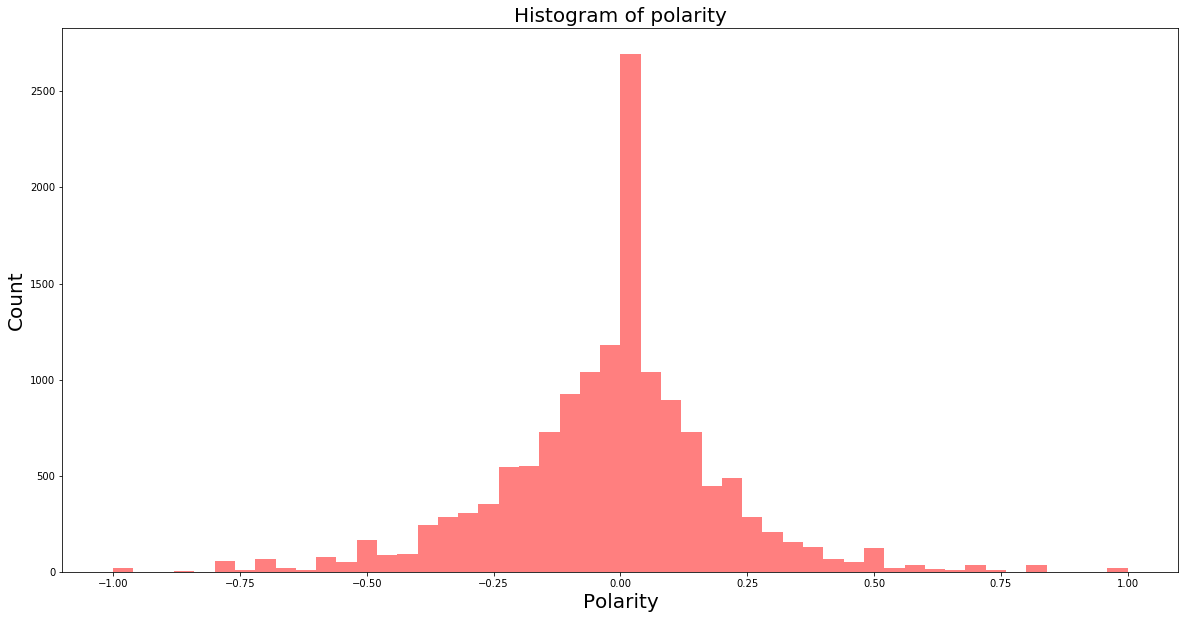

In [181]:
num_bins = 50
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(sampleSuicideWatch_list.polarity, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
plt.title('Histogram of polarity',fontsize =20)
plt.show()

### 2.Depressed

In [15]:
### Because of relatively huge dataset, we need to perform random sampling of 80% for now
depressed_list = depressed_df.sample(frac=0.8, replace=True, random_state=1)

In [16]:
depressed_list["title_with_selftext_clean"] = depressed_list["title_with_selftext"].apply(lambda x: clean_words(x))

In [17]:
depressed_list.head(1)

author over_18                title  \
236  L0st_W1sd0m   False  Just help me please   

                                              selftext  num_comments  score  \
236  I just feel horrible constantly but I’m forced...             2      1   

                                             full_link  created_utc  \
236  https://www.reddit.com/r/depressed/comments/e8...   1575874155   

              timestamp  subreddit  \
236 2019-12-09 01:49:15  depressed   

                                   title_with_selftext  \
236  Just help me pleaseI just feel horrible consta...   

                             title_with_selftext_clean  
236  help pleasei feel horrible constantly i’m forc...

In [18]:
depressed_list['polarity'] = depressed_list['title_with_selftext_clean'].apply(detect_polarity)

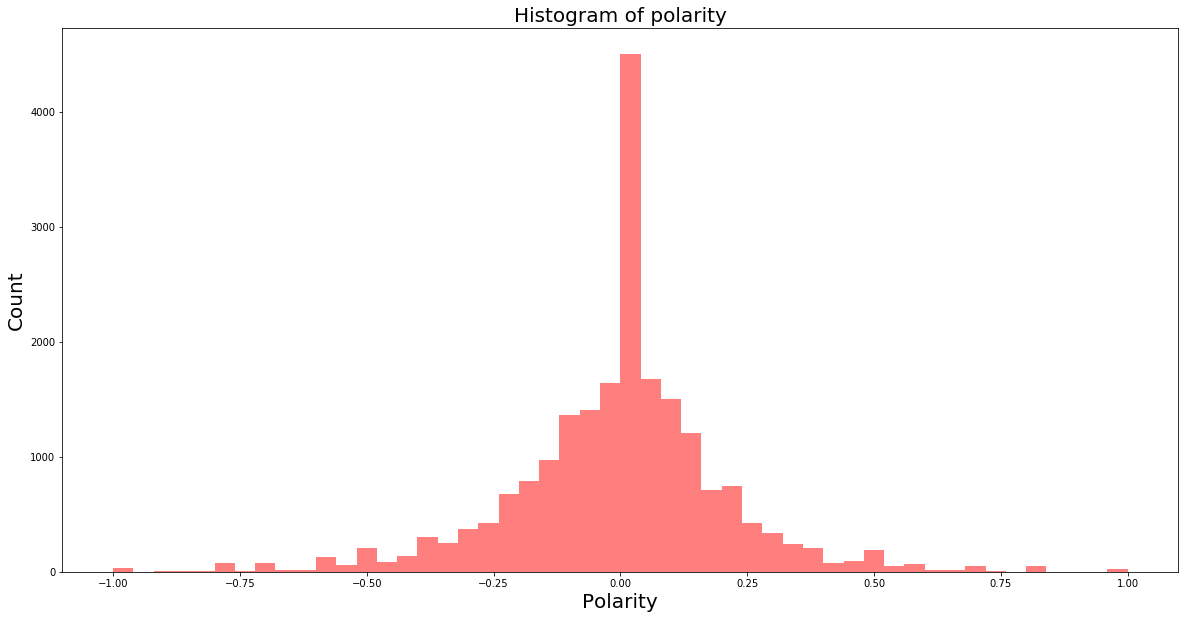

In [19]:
num_bins = 50
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(depressed_list.polarity, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
plt.title('Histogram of polarity',fontsize =20)
plt.show()

### 3.Happy

In [20]:
### Because of relatively huge dataset, we need to perform random sampling of 50% for now
happy_list = happy_df.sample(frac=0.5, replace=True, random_state=1)

In [21]:
happy_list["title_with_selftext_clean"] = happy_list["title_with_selftext"].apply(lambda x: clean_words(x))

In [22]:
happy_list.head(1)

author over_18      title   selftext  num_comments  score  \
33424  meatballsubreddit   False  I’m happy  [removed]             1      1   

                                               full_link  created_utc  \
33424  https://www.reddit.com/r/happy/comments/dhfi2s...   1570996106   

                timestamp subreddit title_with_selftext  \
33424 2019-10-13 15:48:26     happy  I’m happy[removed]   

      title_with_selftext_clean  
33424          i’m happyremoved

In [23]:
happy_list['polarity'] = happy_list['title_with_selftext_clean'].apply(detect_polarity)

In [ ]:
##positive example

In [100]:
extreme_example =happy_list[happy_list['polarity']==1.0]

In [105]:
extreme_example['title'].tail(5).tolist()

['Best motivational video to stay motivated',
 'Best friend rings',
 'Expecting our firstborn! During a time that seems hopeless, it’s wonderful to have something to look forward to!',
 'I got my best friend back!!!',
 'My roommate and I just had the best laugh']

In [24]:
num_bins = 50
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(happy_list.polarity, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
plt.title('Histogram of polarity',fontsize =20)
plt.show()

### 4.Self-improvement

In [25]:
### Because of relatively huge dataset, we need to perform random sampling of 50% for now
selfimprovement_list = selfimprovement_df.sample(frac=0.5, replace=True, random_state=1)

In [26]:
selfimprovement_list["title_with_selftext_clean"] = selfimprovement_list["title_with_selftext"].apply(lambda x: clean_words(x))

In [27]:
selfimprovement_list.head(1)

author over_18  \
33176  ParsnipParadise   False   

                                                   title  \
33176  Books or Podcasts for learning how to assert y...   

                                                selftext  num_comments  score  \
33176  I'm sitting here listening to Outliers by Malc...             0      1   

                                               full_link  created_utc  \
33176  https://www.reddit.com/r/selfimprovement/comme...   1574105489   

                timestamp        subreddit  \
33176 2019-11-18 14:31:29  selfimprovement   

                                     title_with_selftext  \
33176  Books or Podcasts for learning how to assert y...   

                               title_with_selftext_clean  
33176  book podcasts learning assert need communicate...

In [28]:
selfimprovement_list['polarity'] = selfimprovement_list['title_with_selftext_clean'].apply(detect_polarity)

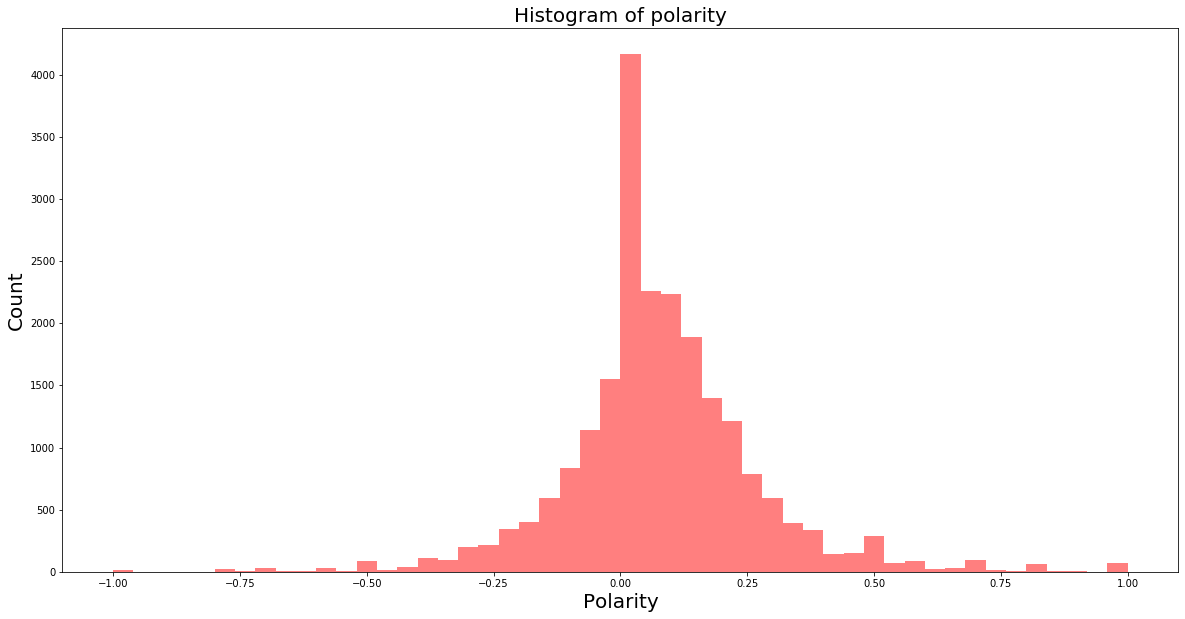

In [29]:
num_bins = 50
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(selfimprovement_list.polarity, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
plt.title('Histogram of polarity',fontsize =20)
plt.show()

### Polarity Descriptive Statistics comparison plot by 4 different subreddit  groups

In [30]:
sampleSuicideWatch_list['polarity'].describe()

count    23850.000000
mean        -0.025652
std          0.222685
min         -1.000000
25%         -0.126977
50%          0.000000
75%          0.081699
max          1.000000
Name: polarity, dtype: float64

In [31]:
depressed_list['polarity'].describe()

count    21270.000000
mean        -0.005429
std          0.214168
min         -1.000000
25%         -0.100000
50%          0.000000
75%          0.100000
max          1.000000
Name: polarity, dtype: float64

In [32]:
selfimprovement_list['polarity'].describe()

count    22098.000000
mean         0.075214
std          0.195665
min         -1.000000
25%         -0.006250
50%          0.060000
75%          0.166549
max          1.000000
Name: polarity, dtype: float64

In [33]:
happy_list['polarity'].describe()

count    20470.000000
mean         0.237013
std          0.282833
min         -1.000000
25%          0.000000
50%          0.200000
75%          0.400000
max          1.000000
Name: polarity, dtype: float64

### Polarity Distribution comparison plot by 4 different subreddit  groups

In [42]:
from matplotlib import pyplot
plt.figure(figsize=(20,10))
bins = np.linspace(-.8, .8, 35)

pyplot.hist(sampleSuicideWatch_list['polarity'], bins, alpha=0.9, label='suicide',color='black')
pyplot.hist(depressed_list['polarity'], bins, alpha=0.9, label='depressed',color='red')
pyplot.hist(selfimprovement_list['polarity'], bins, alpha=0.9, label='self-improvement',color='blue')
pyplot.hist(happy_list['polarity'], bins, alpha=0.9, label='happy',color='yellow')

plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
pyplot.legend(loc='upper right',fontsize=20)
plt.title('Subreddit polarity distribution',fontsize =20)

pyplot.show()